In [395]:
import numpy as np
import json
from scipy.interpolate import Rbf

# path='/home/e.sharaborin/results/tube/res22_adaptffsu/upd_calc/'
# fn = 'r_over_x_t=16.1542.csv'
# with open(path + fn, 'r') as f:
#     lists = json.load(f)
#     x, y, x_box_smooth, y_box_smooth, x_sorted, y_sorted = np.array(lists[0]), np.array(lists[1]), np.array(lists[2]), np.array(lists[3]), np.array(lists[4]), np.array(lists[5])

path='/home/e.sharaborin/basilisk/work/tube/'
fn = 'r_over_x_total_t=0.989.csv'
#fn = 'r_over_x_t=11.9414.csv'

path = '/home/e.sharaborin/Dropbox/Oleg-Evgenii/dumps/'
fn = 'r_over_x_total_t=16.1542.csv'
with open(path + fn, 'r') as f:
    lists = json.load(f)
    x, y = np.array(lists[0]), np.array(lists[1])



# x, y, z, d = np.random.rand(4, 50)
# rbfi = Rbf(x, y, z, d)  # radial basis function interpolator instance
# xi = yi = zi = np.linspace(0, 1, 20)
# di = rbfi(xi, yi, zi)   # interpolated values
# di.shape

In [79]:
def find_next_box(x, y, x0k, y0k, dx, dy, i, j):
        ind = (x0k - (0.5 + i)*dx <= x) & (x <= x0k + (0.5 + i)*dx) & (y0k - (0.5 + j)*dy <= y) & (y <= y0k + (0.5 + j)*dy)
        xk = x[ind].mean()
        yk = y[ind].mean()
        return xk, yk, x[ind].size

In [132]:
# # Define the borders
# deltaX = (max(x) - min(x))/10
# deltaY = (max(y) - min(y))/10
# xmin = min(x) - deltaX
# xmax = max(x) + deltaX
# ymin = min(y) - deltaY
# ymax = max(y) + deltaY
# xl = np.linspace(xmin, xmax, 10)
# yl = np.linspace(ymin, ymax, 10)
# print(xmin, xmax, ymin, ymax)
# # Create meshgrid
# xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
# positions = np.vstack([xx.ravel(), yy.ravel()])
# values = np.vstack([x, y])
# kernel = st.gaussian_kde(values)
# f = np.reshape(kernel(positions).T, xx.shape)


In [71]:
# def cartprod(*arrays):
#     N = len(arrays)
#     return np.transpose(np.meshgrid(*arrays, indexing='ij'), 
#                       np.roll(np.arange(N + 1), -1)).reshape(-1, N)

In [115]:
# from sklearn.neighbors import KernelDensity
# import numpy as np
# X = np.c_[x,y]
# kde = KernelDensity(kernel='epanechnikov', bandwidth=0.2).fit(X)
# xx_yy = cartprod(xl,yl)
# f=kde.score_samples(xx_yy)

In [179]:
x.shape

(72561,)

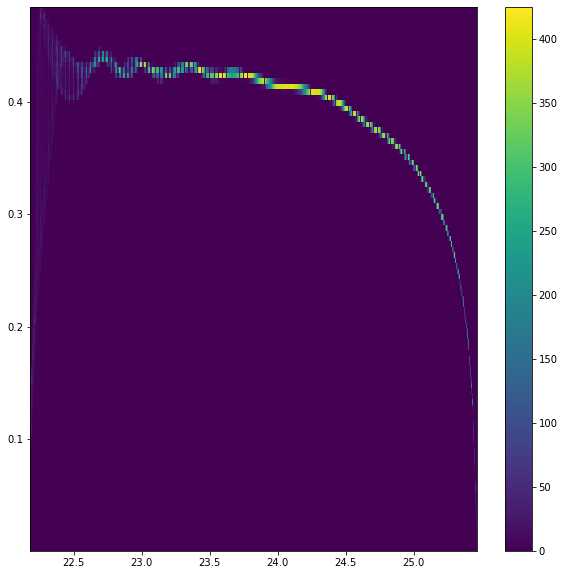

In [396]:
N, M = 1000, 100
plt.figure(figsize=(10, 10 ))
plt.colorbar(image)
h, xedges, yedges, image = plt.hist2d(x, y, bins=[N,M], density=True)
x_sig, y_sig, h_sig = [], [], []
ys, xs = np.mgrid[min(xedges):max(xedges):N*1j, min(yedges):max(yedges):M*1j]
for i in range(N):
    for j in range(M):
        if i < N and j< M and h[i,j] > 1e-8:
            xc = 0.5*(x[i] + x[i+1])
            yc = 0.5*(y[j] + y[j+1])
            x_sig.append(xc)
            y_sig.append(yc)
            h_sig.append(h[i,j])
x_sig = np.asarray(x_sig)
y_sig = np.asarray(y_sig)

ind = h.argmax(axis=1)
x_sig_max = xs[ind,0]
y_sig_max = ys[ind,1]




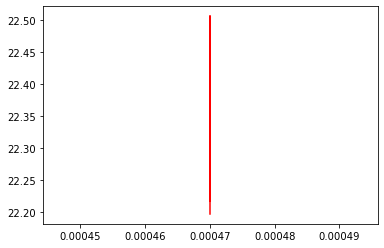

In [397]:
# plt.figure(figsize=(13, 7))
plt.plot(x_sig_max, y_sig_max, 'r-')

xy0= (22.182716369628906, 0.0004700725034859927)
3
[25.20837815  0.27920661] [23.52410607  0.41629224]
Cluster 0 contains 12644 points within -0.11062061480474869:0.2480894309753427
(1333,) (1333,)
(1333,) (1333,)
Cluster 1 contains 216022 points within -1.2994449288691006:1.41921604870859
(1333,) (1333,)
(1333,) (1333,)
Cluster 2 contains 33563 points within -0.27128333069806404:0.34323182107904043
(1333,) (1333,)
(1333,) (1333,)


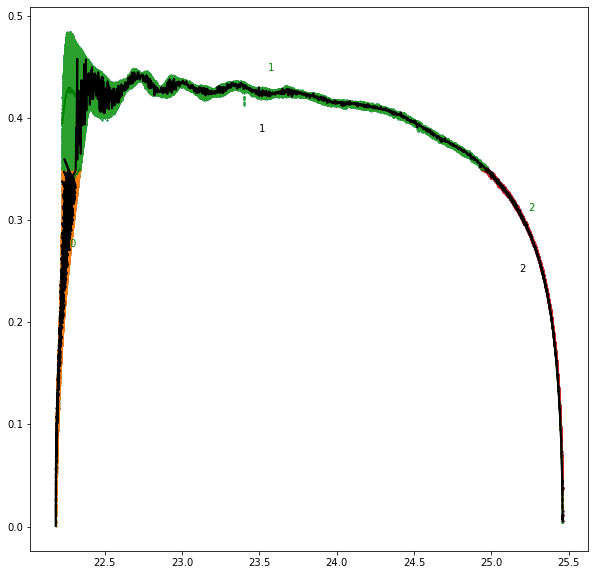

In [418]:
#!/usr/bin/env python

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy import interpolate
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.cluster import KMeans #, SpectralClustering, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
import networkx as nx

def toX(x, y):
    return np.concatenate((x.reshape(-1,1), y.reshape(-1,1)), axis=1)

def fromX(X):
    return X[:,0], X[:,1]

def PCAsort(x, y):
    # PCA
    xy = toX(x, y)
    pca = PCA(2).fit(xy)
    xypca = pca.transform(xy)
    newx, newy = fromX(xypca)

    #sort
    indexSort = np.argsort(newx)
    return newx[indexSort], newy[indexSort], pca

def interp_data(x, y, N):
    f = interpolate.interp1d(x, y, kind='linear')
    newx = np.linspace(x[0], x[-1], N)
    return newx, f(newx)

def align_data(x, y, direction):
    ddir = np.hstack((x[-1] - x[0], y[-1] - y[0]));
    return (x, y) if np.dot(direction, ddir) > 0 else (x[::-1], y[::-1])


# Solution from https://stackoverflow.com/a/63368162/2531400
def XYclean(x, y, window=None, N=None):
    newx, newy, pca = PCAsort(x, y)

    #add some more points (optional)
    newx, newy = interp_data(newx, newy, N)

    #smooth with a filter (optional)
    newy = savgol_filter(newy, window, 2)

    #return back to old coordinates
    xyclean = pca.inverse_transform(toX(newx, newy))

    return fromX(xyclean)

def smoother_vf(xin, yin, N_polynomials = 20, sigma = 1):
    xin_min = min(xin)
    xin_max = max(xin)
    yin_min = min(yin)
    yin_max = max(yin)
    
    x = (xin - xin_min)/(xin_max - xin_min)
    y = (yin - yin_min)/(yin_max - yin_min)

    x = x.reshape((len(x), 1))
    D = np.hstack([np.cos(2*np.pi*x*i) for i in range(N_polynomials)] + [np.sin(2*np.pi*x*i) for i in range(N_polynomials)])
    w = np.linalg.inv(D.T @ D + sigma*np.eye(2*N_polynomials)) @ D.T @ y
    
    X = np.linspace(min(x), max(x), 1000)

    X = X.reshape((len(X), 1))
    D = np.hstack([np.cos(2*np.pi*X*i)for i in range(N_polynomials)] + [np.sin(2*np.pi*X*i) for i in range(N_polynomials)])
    Y = D @ w
    X = X.reshape((len(X), ))
#     plt.plot(x, y, ".", color="grey", alpha=0.3, label="data")
#     plt.plot(X, Y, color="red", label="fit")
#     plt.legend();
    
    return (X + xin_min)*(xin_max - xin_min), (Y + yin_min)*(yin_max - yin_min)

N = 4000
M = 3
Ninterp = N
Nadj = 100
Npca = N//M
window = 40# Ninterp//(2*M)//10
window += 1 if window % 2 == 0 else 0
is_cycle = False


plt.figure(figsize=(10,10))
xmin = x.min()
xmax = x.max()
xcm = 0.5*(xmax + xmin)
inds = x < xcm
ind_xy0 = y[inds].argmin()
xy0 = x[inds][ind_xy0], y[inds][ind_xy0]
print('xy0=', xy0)
plt.scatter(x, y, s=1)

# Split data to chunks (clusters) and plot it
# kmeans = KMeans(n_clusters=M).fit(toX(x, y))
# ccenters = kmeans.cluster_centers_

#split points into 3 parts
cut_y = 0.35
inds = [(y <  cut_y) & (x <  xcm),
        (y >= cut_y),
        (y <  cut_y) & (x >= xcm)]
# first_part  = arr[(y <  cut_y) & (x <  x_cm)]
# second_part = arr[(y >= cut_y) & (x <  x_cm)]
# third_part  = arr[              (x >= x_cm)]

ccenters = np.zeros((M,2))
for i in range(M):
    x_, y_ = np.asarray(x[inds[i]]), np.asarray(y[inds[i]])
    ccenters[i,:]=x_.mean(), y_.mean()
    plt.scatter(x_, y_, s=1)
    plt.text(ccenters[i,0]+.03, ccenters[i,1]+.03, i, color='g')

'''
# 1. Original PCA-based solution from StackOverlow
xc, yc = XYclean(x, y, window=41, N=Ninterp)
plt.plot(xc, yc, 'r', lw=1)
'''

# 2. Hybrid solution: clusterization + PCA
X, Y = np.array([]), np.array([])
for i in range(M):
    x_, y_ = np.asarray(x[inds[i]]), np.asarray(y[inds[i]])
    x_, y_ = XYclean(x_, y_, window=window, N=Npca)
    plt.plot(x_, y_, 'g', lw=2)

# 3. Hybrid solution: clusterization + 2-NN + PCA

# Sort clusters: https://stackoverflow.com/a/37744549/2531400
clf = NearestNeighbors(n_neighbors=2).fit(ccenters)
G = clf.kneighbors_graph(mode='distance')
#print(G)
T = nx.from_scipy_sparse_matrix(G)
i0 = 0  # number of the first cluster
if not is_cycle:
    min_dist = np.inf
    for i in range(M):
        dist = np.linalg.norm(ccenters[i] - xy0)
        if dist < min_dist:
            i0 = i; min_dist = dist

order = list(nx.dfs_preorder_nodes(T, i0))
print(len(order))

X, Y = [], []
for i in range(M):
    j = order[i]
    x_, y_ = np.asarray(x[inds[j]]), np.asarray(y[inds[j]])
    # x_, y_ = x[kmeans.labels_ == j], y[kmeans.labels_ == j]
    plt.text(ccenters[j,0]-.03, ccenters[j,1]-.03, i, color='k')
    x_, y_, pca = PCAsort(x_, y_)
    x_, y_ = fromX(pca.inverse_transform(toX(x_, y_)))
    if i < M-1:
        x_, y_ = align_data(x_, y_, ccenters[order[i+1]] - ccenters[j])
    else:
        print(ccenters[j], ccenters[order[i-1]])
        x_, y_ = align_data(x_, y_, ccenters[j] - ccenters[order[i-1]])
    X.append(x_); Y.append(y_)

XX, YY = np.array([]), np.array([])
for i in range(M):
    # Collect data from the current cluster + neighbours
    i0, iN = Nadj, Nadj
    if i == 0:
        if is_cycle:
            x_ = np.hstack((X[-1][-Nadj:], X[i], X[i+1][:Nadj]))
            y_ = np.hstack((Y[-1][-Nadj:], Y[i], Y[i+1][:Nadj]))
        else:
            x_ = np.hstack((X[i], X[i+1][:Nadj]))
            y_ = np.hstack((Y[i], Y[i+1][:Nadj]))
            i0 = 0
    elif i == M-1:
        if is_cycle:
            x_ = np.hstack((X[i-1][-Nadj:], X[i], X[0][:Nadj]))
            y_ = np.hstack((Y[i-1][-Nadj:], Y[i], Y[0][:Nadj]))
        else:
            x_ = np.hstack((X[i-1][-Nadj:], X[i]))
            y_ = np.hstack((Y[i-1][-Nadj:], Y[i]))
            iN = 1
    else:
        x_ = np.hstack((X[i-1][-Nadj:], X[i], X[i+1][:Nadj]))
        y_ = np.hstack((Y[i-1][-Nadj:], Y[i], Y[i+1][:Nadj]))

    # Apply SavGol to interpolated data in PCA coordinates
    pca = PCA(2)
    x_, y_ = fromX(pca.fit_transform(toX(x_, y_)))
    xmin = min(x_[i0], x_[-iN])
    xmax = max(x_[i0], x_[-iN])
    print(f"Cluster {i} contains {X[i].size} points within {xmin}:{xmax}")

    x_, y_ = interp_data(x_, y_, Ninterp//M)
    print(x_.shape, y_.shape)
#     y_ = savgol_filter(y_, window, 2)
#     x_, y_ = smoother_vf(x_, y_, N_polynomials = 40, sigma = 0.1)
    print(x_.shape, y_.shape)
    mask = (x_ > xmin)*(x_ < xmax)
    x_, y_ = fromX(pca.inverse_transform(toX(x_[mask], y_[mask])))

    # Fill 1-D arrays
    XX = np.hstack((XX, x_))
    YY = np.hstack((YY, y_))

plt.plot(XX, YY, 'k', lw=2)
plt.show()


In [413]:
window

41

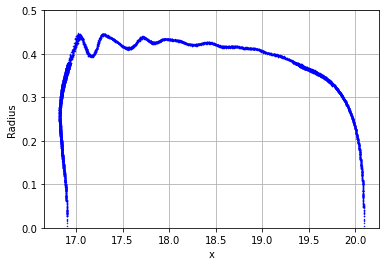

In [263]:
msize = 1
plt.figure()
#plot raw points
plt.plot(x_sig, y_sig, 'b.',  markersize=msize,  linewidth=0.5, label='raw')
plt.xlabel('x')
plt.ylabel('Radius')
plt.ylim(0, 0.5)
plt.grid()

In [264]:
import numpy as np
import scipy
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA

def XYclean(x,y, window=41, N=500): 

    xy = np.concatenate((x.reshape(-1,1), y.reshape(-1,1)), axis=1)     

    # make PCA object
    pca = PCA(2)
    # fit on data
    pca.fit(xy)
    
    #transform into pca space   
    xypca = pca.transform(xy) 
    newx = xypca[:,0]
    newy = xypca[:,1]

    #sort
    indexSort = np.argsort(x)
    newx = newx[indexSort]
    newy = newy[indexSort]

    #add some more points (optional)
    f = scipy.interpolate.interp1d(newx, newy, kind='linear')        
    newX=np.linspace(np.min(newx), np.max(newx), N)
    newY = f(newX)            

    #smooth with a filter (optional)
    newY = savgol_filter(newY, window, 2)

    #return back to old coordinates
    xyclean = pca.inverse_transform(np.concatenate((newX.reshape(-1,1), newY.reshape(-1,1)), axis=1) )
    xc=xyclean[:,0]
    yc = xyclean[:,1]

    return xc, yc

In [265]:
x_new, y_new = XYclean(x_sig,y_sig)

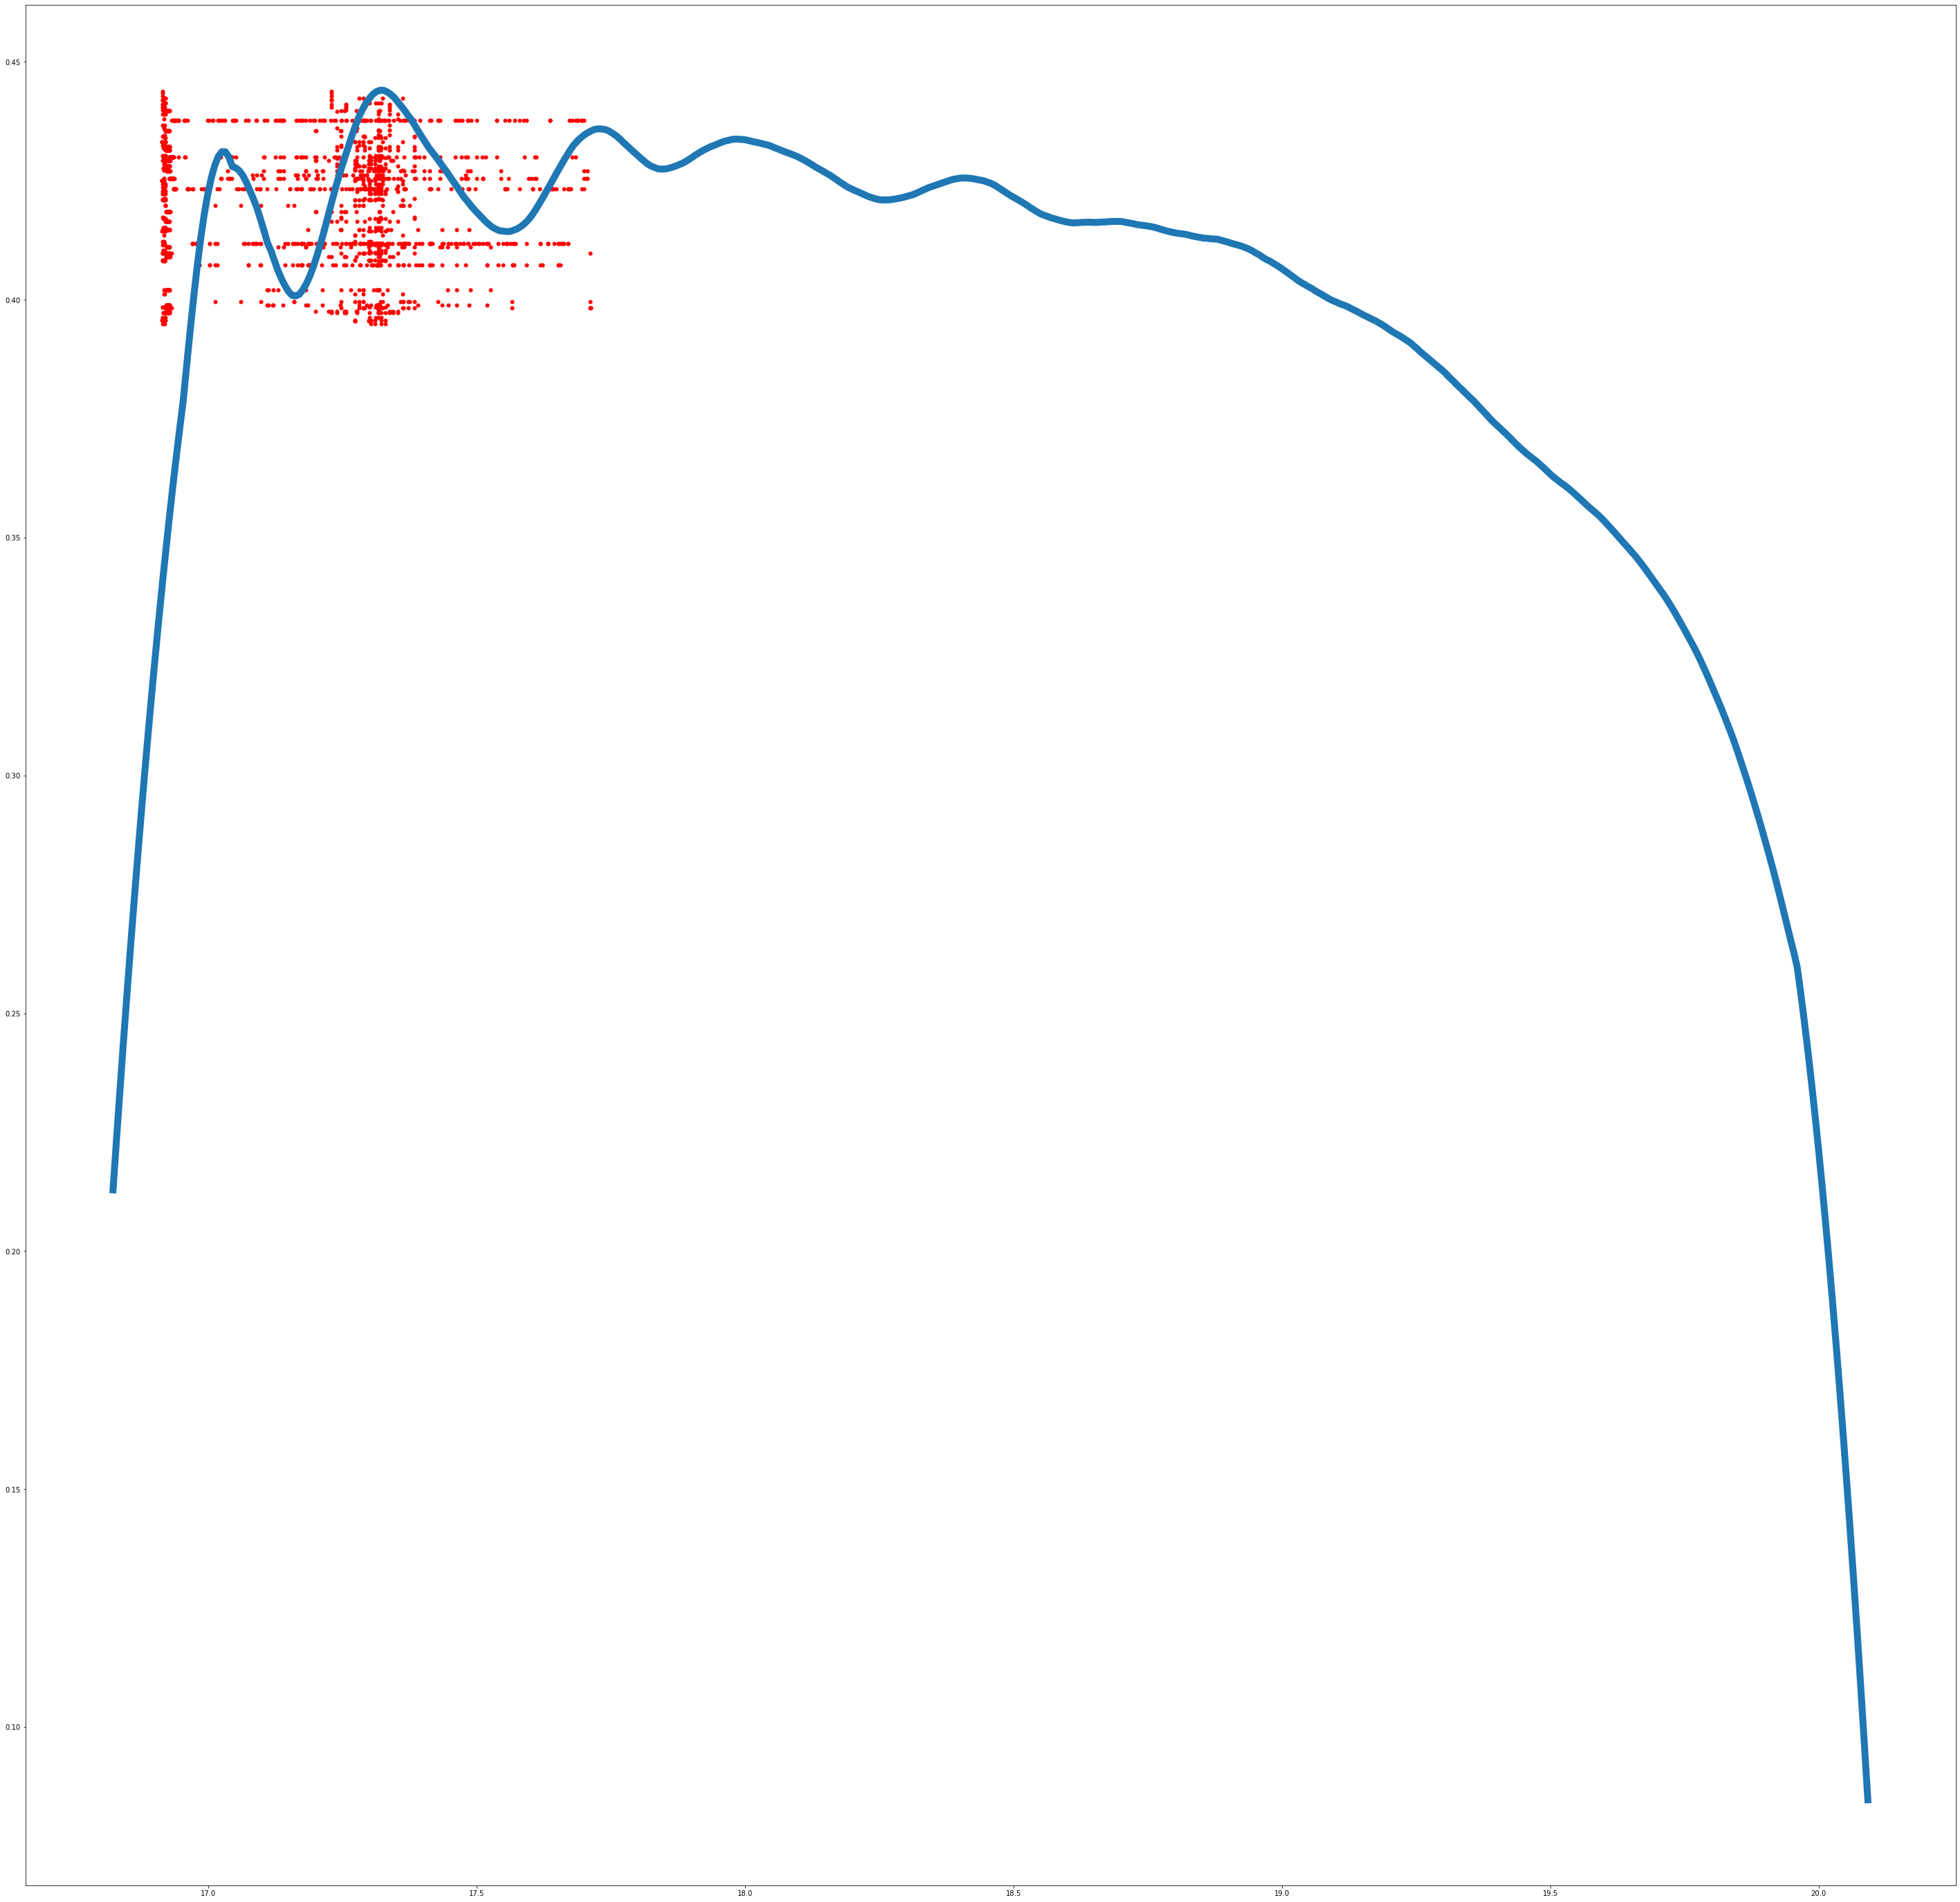

In [390]:
msize = 10
plt.figure(figsize=(50, 50 ))

plt.plot(x_sig, y_sig, 'r.',  markersize=msize,  linewidth=1, label='raw')
plt.plot(x_new, y_new,  linewidth=10)

In [234]:
x_new, y_new = XYclean(x,y)

In [233]:
x.shape

(72561,)

\ub_\tau=\ub - (\ub\cdot \nb)
\grad \ub_\tau = \grad\ub - \grad(\ub\cdot \nb)
\grad \ub_\tau \nb= \grad\ub \nb - \grad(\ub\cdot\nb)\nb
\partial_i u_i

\kappa = \div\nb



40
[6.14583929 0.11758379] [6.0922799  0.20384359]
Cluster 0 contains 232 points within 0.05264894466348841:0.14636970024817603
Cluster 1 contains 300 points within 0.04010127697860052:0.13331026685559563
Cluster 2 contains 369 points within 0.03620229848799016:0.11862870212621447
Cluster 3 contains 359 points within 0.036683568655867436:0.09310140689687435
Cluster 4 contains 417 points within 0.01981243452221888:0.04435877584591349
Cluster 5 contains 440 points within -0.028698091163418583:0.06060111843182354
Cluster 6 contains 372 points within -0.0585983303428081:0.030502471481573874
Cluster 7 contains 372 points within -0.05909894289049155:0.030028813733525325
Cluster 8 contains 480 points within -0.07426817608699804:0.04456734516890108
Cluster 9 contains 480 points within -0.044561061208332295:0.07426844877632105
Cluster 10 contains 360 points within -0.02971249434836285:0.059425519622374315
Cluster 11 contains 372 points within -0.029306425930575437:0.05984654471087411
Cluster 12

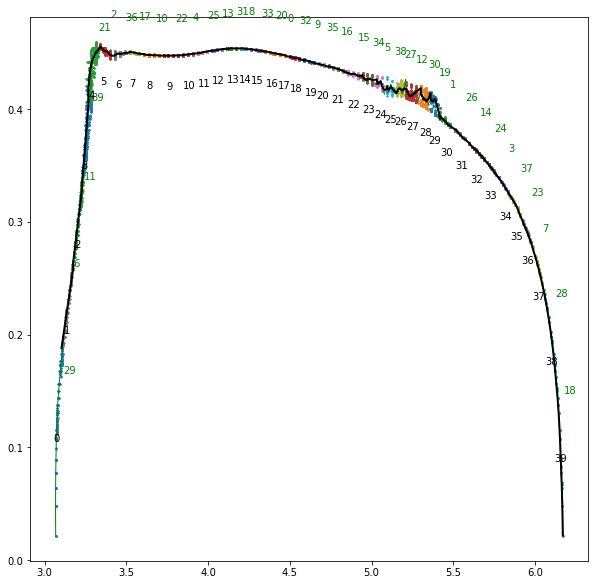

In [388]:
#old version
#!/usr/bin/env python

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy import interpolate
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.cluster import KMeans #, SpectralClustering, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
import networkx as nx

def toX(x, y):
    return np.concatenate((x.reshape(-1,1), y.reshape(-1,1)), axis=1)

def fromX(X):
    return X[:,0], X[:,1]

def PCAsort(x, y):
    # PCA
    xy = toX(x, y)
    pca = PCA(2).fit(xy)
    xypca = pca.transform(xy)
    newx, newy = fromX(xypca)

    #sort
    indexSort = np.argsort(newx)
    return newx[indexSort], newy[indexSort], pca

def interp_data(x, y, N):
    f = interpolate.interp1d(x, y, kind='linear')
    newx = np.linspace(x[0], x[-1], N)
    return newx, f(newx)

def align_data(x, y, direction):
    ddir = np.hstack((x[-1] - x[0], y[-1] - y[0]));
    return (x, y) if np.dot(direction, ddir) > 0 else (x[::-1], y[::-1])


# Solution from https://stackoverflow.com/a/63368162/2531400
def XYclean(x, y, window=None, N=None):
    newx, newy, pca = PCAsort(x, y)

    #add some more points (optional)
    newx, newy = interp_data(newx, newy, N)

    #smooth with a filter (optional)
    newy = savgol_filter(newy, window, 2)

    #return back to old coordinates
    xyclean = pca.inverse_transform(toX(newx, newy))

    return fromX(xyclean)

N = 20000
M = 40
Ninterp = N
Nadj = 2
Npca = N//M
window = Ninterp//(2*M)
window += 1 if window % 2 == 0 else 0
is_cycle = False


plt.figure(figsize=(10,10))

xmin = x.min()
xmax = x.max()
xcm = 0.5*(xmax + xmin)
ind_xy0 = y[x < xcm].argmin()
xy0 = x[ind_xy0], y[ind_xy0]
# Generate noisy and shuffled data
plt.scatter(x, y, s=1)

# Split data to chunks (clusters) and plot it
kmeans = KMeans(n_clusters=M).fit(toX(x, y))
ccenters = kmeans.cluster_centers_
for i in range(M):
    x_, y_ = x[kmeans.labels_ == i], y[kmeans.labels_ == i]
    plt.scatter(x_, y_, s=1)
    plt.text(ccenters[i,0]+.03, ccenters[i,1]+.03, i, color='g')

'''
# 1. Original PCA-based solution from StackOverlow
xc, yc = XYclean(x, y, window=41, N=Ninterp)
plt.plot(xc, yc, 'r', lw=1)
'''

# 2. Hybrid solution: clusterization + PCA
X, Y = np.array([]), np.array([])
for i in range(M):
    x_, y_ = x[kmeans.labels_ == i], y[kmeans.labels_ == i]
    x_, y_ = XYclean(x_, y_, window=window, N=Npca)
    plt.plot(x_, y_, 'g', lw=1)

# 3. Hybrid solution: clusterization + 2-NN + PCA

# Sort clusters: https://stackoverflow.com/a/37744549/2531400
clf = NearestNeighbors(n_neighbors=2).fit(ccenters)
G = clf.kneighbors_graph(mode='distance')
#print(G)
T = nx.from_scipy_sparse_matrix(G)
i0 = 0  # number of the first cluster
if not is_cycle:
    min_dist = np.inf
    for i in range(M):
        dist = np.linalg.norm(ccenters[i] - xy0)
        if dist < min_dist:
            i0 = i; min_dist = dist

order = list(nx.dfs_preorder_nodes(T, i0))
print(len(order))

X, Y = [], []
for i in range(M):
    j = order[i]
    x_, y_ = x[kmeans.labels_ == j], y[kmeans.labels_ == j]
    plt.text(ccenters[j,0]-.03, ccenters[j,1]-.03, i, color='k')
#     x_, y_, pca = PCAsort(x_, y_)
#     x_, y_ = fromX(pca.inverse_transform(toX(x_, y_)))
    if i < M-1:
        x_, y_ = align_data(x_, y_, ccenters[order[i+1]] - ccenters[j])
    else:
        print(ccenters[j], ccenters[order[i-1]])
        x_, y_ = align_data(x_, y_, ccenters[j] - ccenters[order[i-1]])
    X.append(x_); Y.append(y_)

XX, YY = np.array([]), np.array([])
for i in range(M):
    # Collect data from the current cluster + neighbours
    i0, iN = Nadj, Nadj
    if i == 0:
        if is_cycle:
            x_ = np.hstack((X[-1][-Nadj:], X[i], X[i+1][:Nadj]))
            y_ = np.hstack((Y[-1][-Nadj:], Y[i], Y[i+1][:Nadj]))
        else:
            x_ = np.hstack((X[i], X[i+1][:Nadj]))
            y_ = np.hstack((Y[i], Y[i+1][:Nadj]))
            i0 = 0
    elif i == M-1:
        if is_cycle:
            x_ = np.hstack((X[i-1][-Nadj:], X[i], X[0][:Nadj]))
            y_ = np.hstack((Y[i-1][-Nadj:], Y[i], Y[0][:Nadj]))
        else:
            x_ = np.hstack((X[i-1][-Nadj:], X[i]))
            y_ = np.hstack((Y[i-1][-Nadj:], Y[i]))
            iN = 1
    else:
        x_ = np.hstack((X[i-1][-Nadj:], X[i], X[i+1][:Nadj]))
        y_ = np.hstack((Y[i-1][-Nadj:], Y[i], Y[i+1][:Nadj]))

    # Apply SavGol to interpolated data in PCA coordinates
    pca = PCA(2)
    x_, y_ = fromX(pca.fit_transform(toX(x_, y_)))
    xmin = min(x_[i0], x_[-iN])
    xmax = max(x_[i0], x_[-iN])
    print(f"Cluster {i} contains {X[i].size} points within {xmin}:{xmax}")

    x_, y_ = interp_data(x_, y_, Ninterp//M)
    y_ = savgol_filter(y_, window, 2)
    mask = (x_ > xmin)*(x_ < xmax)
    x_, y_ = fromX(pca.inverse_transform(toX(x_[mask], y_[mask])))

    # Fill 1-D arrays
    XX = np.hstack((XX, x_))
    YY = np.hstack((YY, y_))

plt.plot(XX, YY, 'k', lw=2)
plt.show()


In [421]:
a = np.arange(10)
a[::-1]

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])